# Landsat Data: Explore and Download using landsatxplore

**landsatxplorer** is a Python library designed for searching and downloading Landsat imagery from the USGS EarthExplorer platform. It allows users to query Landsat datasets by various parameters like location, date, and cloud cover, and download the corresponding images. This tool simplifies the process of accessing and working with satellite imagery for analysis and visualization in Python

**Information on Library:**
* Library: landsatxplore
* Author: str.ucture GmbH
* Notebook Version: 1.3 (Updated: January 10, 2024)

While the library is open-source, it has several limitations:
* Downloads satellite images as **.tar** files, with each band stored as a separate GeoTIFF.
* Lacks functionality to filter or clip images by bounding box, requiring additional post-processing.
* Outdated (last updated 3 years ago); installing it may disrupt other libraries. Use `pip install --upgrade libraryName` if issues arise.

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\landsatxplorer\download"
working_folder = r".\data\landsatxplorer\working"
geotiff_folder = r".\data\landsatxplorer\geotiff"
csv_folder = r".\data\landsatxplorer\csv"
output_folder = r".\data\landsatxplorer\output"
''' ----- Ende der Eingaben ---- '''

# Create directories if they do not exist
os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Filter and Retrieve Satellite Images Metadata

### 2.1 API and Authentication

To authenticate with the USGS API, follow these steps:

1. **Register**: Create an account at the [USGS registration page](https://ers.cr.usgs.gov/register/).
2. **Obtain Credentials**: After registering, go to **"Application Tokens"** and click **"Create Application Token."**  
   - Choose a name for the token and set an expiration date.  
   - Ensure that **M2M API** is selected.  
   - Once the token is created, copy it and store it securely, as it will no longer be visible after **60 seconds**.  

#### **Example**:
The `*.json` file should have the following format:

```json
{
    "username": "your_username",
    "token": "your_token"
}
```

---

* **Important**: Due to changes in the authentication process at USGS, an API token is now required instead of a password. Additionally, since the original contributor no longer maintains landsatxplore, this notebook uses a different GitHub repository where another contributor has implemented the necessary authentication updates.

* To install the working version of landsatxplore, run the following command:

* ``pip install git+https://github.com/jsearcy1/landsatxplore.git``

----

In [2]:
import json
from landsatxplore.api import API

# Load credentials from the local JSON file
with open(r"D:/usgs.json", "r") as file:
    credentials = json.load(file)

username = credentials["username"]
token = credentials["token"]

### 2.2 Define Data Query Parameters

In [3]:
# Define dataset name and search parameters
# Dataset Name and Dataset ID can be found at https://github.com/yannforget/landsatxplore
dataset = 'landsat_ot_c2_l2'
latlon = [47.6780, 9.1737]  # Konstanz
start_date = '2020-01-01'
end_date = '2020-10-01'
max_cloud_cover = 10

### 2.2 Search the Available Scenes

In [4]:
# Authenticate with the USGS API
api = API(username=username, password=token)

# Search for available scenes for the given dataset
scenes = api.search(
    dataset = dataset,
    latitude = latlon[0],
    longitude = latlon[1],
    start_date = start_date,
    end_date = end_date,
    max_cloud_cover = max_cloud_cover
)

# Output the number of scenes found
print(f"{len(scenes)} scenes found.")

# Logout from the API
api.logout()

8 scenes found.


### 2.3 Create a Dictionary to store all the Scene Information

In [5]:
import pandas as pd

# Convert scene data into a Dataframe
df = pd.DataFrame([
    {
        "entity_id": scene["entity_id"],
        "display_id": scene["display_id"],
        "acq_date": scene["acquisition_date"],
        "scene_cloud_cover": scene["scene_cloud_cover"],
        "land_cloud_cover": scene["land_cloud_cover"],
        # "image_quality": scene["image_quality"],  # Uncomment if needed
        # "day_night": scene["day-night_indicator"],  # Uncomment if needed
        "sun_azimuth": scene["sun_azimuth_l0ra"],  # Recommended range: 90-270 degrees
        "sun_elevation": scene["sun_elevation_l0ra"]  # Recommended range: 50-90 degrees
    }
    for scene in scenes
])

# Modify the Pandas display options
pd.set_option('display.max_colwidth', 15)

# Display the DataFrame
df.head(8)

,entity_id,display_id,acq_date,scene_cloud_cover,land_cloud_cover,sun_azimuth,sun_elevation
0,LC819502720...,LC08_L2SP_1...,2020-09-12,9.18,9.18,156.215019,44.101558
1,LC819402720...,LC08_L2SP_1...,2020-08-20,5.51,5.51,149.829906,51.441079
2,LC819502720...,LC08_L2SP_1...,2020-08-11,8.02,8.02,147.421532,53.924649
3,LC819502720...,LC08_L2SP_1...,2020-06-24,3.12,3.12,141.817662,61.728886
4,LC819402720...,LC08_L2SP_1...,2020-06-01,5.08,5.08,144.886824,61.052324
5,LC819502720...,LC08_L2SP_1...,2020-05-07,1.80,1.80,149.179967,56.408805
6,LC819502720...,LC08_L2SP_1...,2020-04-05,2.01,2.01,152.809102,45.887567
7,LC819502720...,LC08_L2SP_1...,2020-01-16,1.56,1.56,159.999515,19.169424


### 2.4 Visuale the Scenes as Polygons over a Map

In [6]:
import folium
from shapely import wkt
from matplotlib import pyplot as plt

# Define colormap with normalized indices
cmap = plt.get_cmap("turbo", 20)

# Initialize folium map with a default location
m = folium.Map(location=[47.5, 8.0],
               zoom_start=7,
               height=450,
               scrollWheelZoom=False)

# Loop through scenes to add polygons
for i, scene in enumerate(scenes):
    entity_id = scene['entity_id']
    entity_cc = scene['cloud_cover']
    polygon_wkt = scene["spatial_coverage"]

    # Parse polygon from WKT string
    polygon = wkt.loads(polygon_wkt) if isinstance(polygon_wkt, str) else polygon_wkt

    # Generate color based on the index
    color = [int(c * 255) for c in cmap(i)[:3]]

    # Create feature group for each scene
    polygon_fg = folium.FeatureGroup(name=f"ID: {entity_id} (CC: {entity_cc})")

    # Add polygon to the map
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in polygon.exterior.coords],
        color=f"rgb({color[0]}, {color[1]}, {color[2]})",
        fill=True,
        fill_opacity=0.1,
    ).add_to(polygon_fg)

    # Add feature group to the map
    polygon_fg.add_to(m)

# Add layer control and display the map
folium.LayerControl().add_to(m)
m

### 2.5 Download Scene(s) using the Display ID

In [7]:
from landsatxplore.earthexplorer import EarthExplorer

# Initialize EarthExplorer
api = API(username=username, password=token)
ee = EarthExplorer(username, token)

# Define the scene identifier and download path
identifier = 'LC08_L2SP_195027_20200624_20200824_02_T1'
download_filename = f"{identifier}.tar"
download_filepath = os.path.join(download_folder, download_filename)

# Download the dataset only if the dataset has not been downloaded before
if not os.path.isfile(download_filepath):
    ee.download(identifier=identifier, output_dir=download_folder)
else:
    print(f"The dataset {identifier} is already downloaded. Skipping download.")

# Logout from the API and EarthExplorer
api.logout()
ee.logout()

The dataset LC08_L2SP_195027_20200624_20200824_02_T1 is already downloaded. Skipping download.


### 2.6 Extract the TAR file in folder

In [8]:
import tarfile

# Define extraction folder path
extract_folder = os.path.join(working_folder, identifier)
os.makedirs(extract_folder, exist_ok=True)

# Extract the ZIP file
try:
    if not os.listdir(extract_folder):
        with tarfile.open(download_filepath) as tar:
            tar.extractall(path=extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {download_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {download_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Merge RGB Bands into a Single GeoTIFF File

### 3.1 Create a Dataframe of all the Available Files

In [9]:
import re

# Extract metadata from the filename.
def meta(filename):
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        bandname=filename.replace(f"{identifier}_","").replace(".TIF", "")
    )

# Create a DataFrame from the list of .TIF files in the extracted directory
file_list = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.TIF')]
df_files = pd.DataFrame.from_dict(file_list)

# Display the DataFrame
df_files

,filename,path,bandname
0,LC08_L2SP_1...,.\data\land...,QA_PIXEL
1,LC08_L2SP_1...,.\data\land...,QA_RADSAT
2,LC08_L2SP_1...,.\data\land...,SR_B1
3,LC08_L2SP_1...,.\data\land...,SR_B2
4,LC08_L2SP_1...,.\data\land...,SR_B3
5,LC08_L2SP_1...,.\data\land...,SR_B4
6,LC08_L2SP_1...,.\data\land...,SR_B5
7,LC08_L2SP_1...,.\data\land...,SR_B6
8,LC08_L2SP_1...,.\data\land...,SR_B7
9,LC08_L2SP_1...,.\data\land...,SR_QA_AEROSOL


### 3.2 Define a Dictionary for Band names mapping

In [10]:
# Dictionary mapping band names to their descriptions
band_descriptions = {
    'QA_PIXEL': 'Quality Assessment Pixel (general quality information about each pixel)',
    'QA_RADSAT': 'Quality Assessment for Rad Saturation',
    'SR_B1': 'Band 1: Coastal/Aerosol (430-450 nm)',
    'SR_B2': 'Band 2: Blue (450-515 nm)',
    'SR_B3': 'Band 3: Green (525-600 nm)',
    'SR_B4': 'Band 4: Red (630-680 nm)',
    'SR_B5': 'Band 5: Near Infrared (NIR) (850-880 nm)',
    'SR_B6': 'Band 6: Shortwave Infrared 1 (SWIR1) (1570-1650 nm)',
    'SR_B7': 'Band 7: Shortwave Infrared 2 (SWIR2) (2110-2290 nm)',
    'SR_QA_AEROSOL': 'Quality Assessment for Aerosol (related to atmospheric conditions)',
    'ST_ATRAN': 'Atmospheric Transmission (fraction of incoming solar radiation)',
    'ST_B10': 'Band 10: Thermal Infrared 1 (TIR1) (10.60-11.19 µm)',
    'ST_CDIST': 'Cloud Distance (distance to the closest cloud)',
    'ST_DRAD': 'Radiance (measure of energy per unit area)',
    'ST_EMIS': 'Emissivity (related to surface temperature)',
    'ST_EMSD': 'Emissivity Standard Deviation',
    'ST_QA': 'Quality Assessment for thermal bands',
    'ST_TRAD': 'Radiant Temperature (measured in Kelvin)',
    'ST_URAD': 'Upwelling Radiance (energy coming from the surface)'
}

# Modify the Pandas display options
pd.reset_option('display.max_colwidth')

# Map band names to descriptions and create a new 'remarks' column
df_files['remarks'] = df_files['bandname'].map(band_descriptions)

# Display only relevant columns
df_files.loc[:, df_files.columns.isin(['bandname', 'remarks'])]

,bandname,remarks
0,QA_PIXEL,Quality Assessment Pixel (general quality info...
1,QA_RADSAT,Quality Assessment for Rad Saturation
2,SR_B1,Band 1: Coastal/Aerosol (430-450 nm)
3,SR_B2,Band 2: Blue (450-515 nm)
4,SR_B3,Band 3: Green (525-600 nm)
5,SR_B4,Band 4: Red (630-680 nm)
6,SR_B5,Band 5: Near Infrared (NIR) (850-880 nm)
7,SR_B6,Band 6: Shortwave Infrared 1 (SWIR1) (1570-165...
8,SR_B7,Band 7: Shortwave Infrared 2 (SWIR2) (2110-229...
9,SR_QA_AEROSOL,Quality Assessment for Aerosol (related to atm...


### 3.3 Define a Function to save a merged GeoTIFF raster

In [11]:
import rasterio

def apply_reflectance_correction(band_data, bandname):
    if bandname in ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']:
        # Apply the reflectance correction (for bands 1-7)
        return (band_data * 2.75e-5) - 0.2
    else:
        return band_data

def apply_thermal_correction(band_data, bandname, no_data_value):
    if bandname == 'ST_B10':
        # Apply the thermal correction (for band 10)
        corrected_data = (band_data * 0.00341802) + 149.0
        
        # Set values of 0 to NoData (cloud cover) using the NoData value
        corrected_data[band_data == 0] = no_data_value
        
        return corrected_data
    else:
        return band_data

def merge_tif(output_filename, bandname_list=None, file_list=None):
    stacked_data = []
    
    # Open the first file to determine the NoData value for the output
    with rasterio.open(file_list[0]['path']) as first_band:
        no_data_value = first_band.nodata  # Retrieve the NoData value from the input raster
    
    for bandname in bandname_list:
        for file in file_list:
            if file['bandname'] == bandname:
                with rasterio.open(file['path']) as band_data:
                    band_array = band_data.read(1)  # Read the first band as array
                    # Apply corrections based on bandname
                    if bandname in ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']:
                        band_array = apply_reflectance_correction(band_array, bandname)
                    elif bandname == 'ST_B10':
                        band_array = apply_thermal_correction(band_array, bandname, no_data_value)
                    stacked_data.append(band_array)

    # Write the merged bands into a new raster file
    output_filepath = os.path.join(geotiff_folder,output_filename)
    with rasterio.open(
        output_filepath,
        'w',
        driver='GTiff',
        height=stacked_data[0].shape[0],
        width=stacked_data[0].shape[1],
        count=len(bandname_list),
        dtype=stacked_data[0].dtype,
        crs=rasterio.open(file_list[0]['path']).crs,
        transform=rasterio.open(file_list[0]['path']).transform,
        nodata=no_data_value  # Set the NoData value for the output file
    ) as dest:
        for idx, band_data in enumerate(stacked_data, start=1):
            dest.write(band_data, idx)

### 3.4 Save GeoTIFF raster

In [12]:
if __name__ == "__main__":
    # Example use case
    bandname_list = ['SR_B1', 'SR_B2', 'SR_B3']
    merge_tif(output_filename="merged_rgb.tif", bandname_list=bandname_list, file_list=file_list)

    # Example use case
    bandname_list = ['ST_B10']
    merge_tif(output_filename="ST_B10_LST.tif", bandname_list=bandname_list, file_list=file_list)

## 4. Satellite Image Analysis and Visualization

### 4.1 Remote Sensing Indices

* Normalized Vegetation Index: NDVI = (NIR-Red)/(NIR+Red)
* Normalized Difference Water Index: NDWI = (Green-NIR)/(Green+NIR)
* Enhanced Vegetation Index : EVI = G * (NIR-Red)/(NIR+C1 x Red-C2 x Blue+L), where G=2.5, C1,C2=6,7.5, L=10000
* Soil Adjusted Vegetation Index: SAVI = {(NIR-Red)*(1+L)}/{NIR + Red + L}, where L: 0.5 (Typically)
* Built-up Index: BUI = (SWIR-NIR)/(SWIR+NIR)

### 4.2 Normalized Vegetation Index (NDVI)

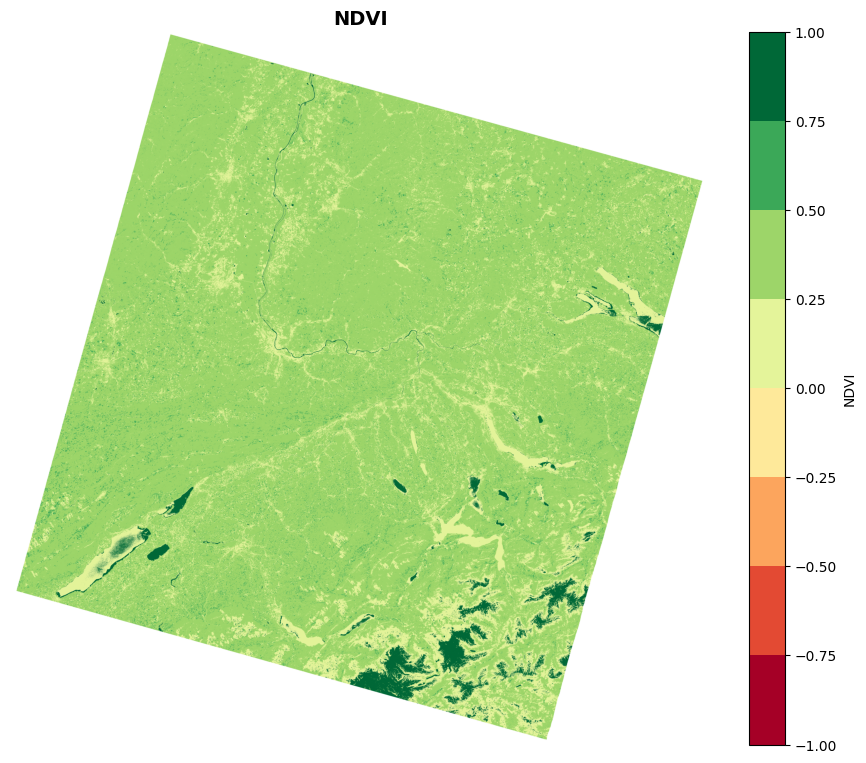

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define the NIR (SR_B5) and Red (SR_B4) bands from the satellite data
required_bandname_list = ['SR_B5', 'SR_B4']

stacked_data = []
for bandname in required_bandname_list:
    for file in file_list:
        if file['bandname'] == bandname:
            with rasterio.open(file['path']) as band_data:
                band_array = band_data.read(1)
                stacked_data.append(band_array)

# Compute NDVI (Add a small number to the denominator to avoid division by zero)
ndvi = (stacked_data[0]-stacked_data[1])/(stacked_data[0]+stacked_data[1]+1e-10)

ndvi_masked = np.ma.masked_where(ndvi ==0, ndvi)

# Plot NDVI
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('RdYlGn',8)
cmap.set_bad(color='white')

im = plt.imshow(ndvi_masked, cmap=cmap, vmin=-1, vmax=1)

# Add a color bar
plt.colorbar(im, fraction=0.046, label='NDVI')

# Set the title for the plot
plt.title('NDVI', fontsize=14, fontweight='bold')

# Remove axis ticks for a cleaner display
plt.axis('off')

# Display the plot
plt.show()

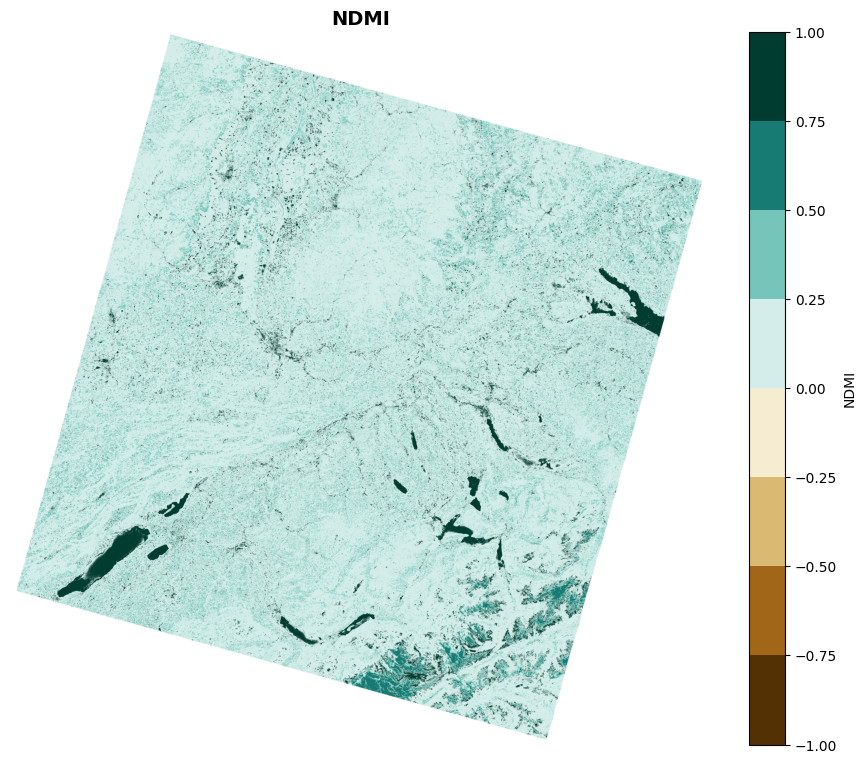

In [14]:
# Define the NIR (SR_B5) and SWIR (SR_B6) bands from the satellite data
required_bandname_list = ['SR_B5', 'SR_B6']

stacked_data = []
for bandname in required_bandname_list:
    for file in file_list:
        if file['bandname'] == bandname:
            with rasterio.open(file['path']) as band_data:
                band_array = band_data.read(1)
                stacked_data.append(band_array)

# Compute NDMI (Add a small number to the denominator to avoid division by zero)
ndmi = (stacked_data[0] - stacked_data[1]) / (stacked_data[0] + stacked_data[1] + 1e-10)

# Mask zero values for better visualization
ndmi_masked = np.ma.masked_where(ndmi == 0, ndmi)

# Plot NDMI
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('BrBG', 8)
cmap.set_bad(color='white')

im = plt.imshow(ndmi_masked, cmap=cmap, vmin=-1, vmax=1)

# Add a color bar
plt.colorbar(im, fraction=0.046, label='NDMI')

# Set the title for the plot
plt.title('NDMI', fontsize=14, fontweight='bold')

# Remove axis ticks for a cleaner display
plt.axis('off')

# Display the plot
plt.show()

## 5. Land Surface Temperature

### 5.1 Plot LST for Complete Dataset

In [ ]:
band_name = 'ST_B10'

for file in file_list:
    if file['bandname'] == band_name:
        with rasterio.open(file['path']) as band_data:
            no_data_value = band_data.nodata        
            band_data_array = band_data.read(1)

            masked_data = np.where(np.isclose(band_data_array, no_data_value, atol=1e-5), np.nan, band_data_array)
            corrected_data = (masked_data * 0.00341802 + 149.0) - 273.15

# Plot LST
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('jet', 20)
cmap.set_bad(color='white')

im = plt.imshow(corrected_data, cmap=cmap, vmin=-10, vmax=40)
plt.colorbar(im, fraction=0.046, label='Land Surface Temperature (LST), °C')
plt.title('Land Surface Temperature', fontsize=14, fontweight='bold')
# plt.axis('off')
plt.show()

### 5.2 Plot LST for Area of Interest

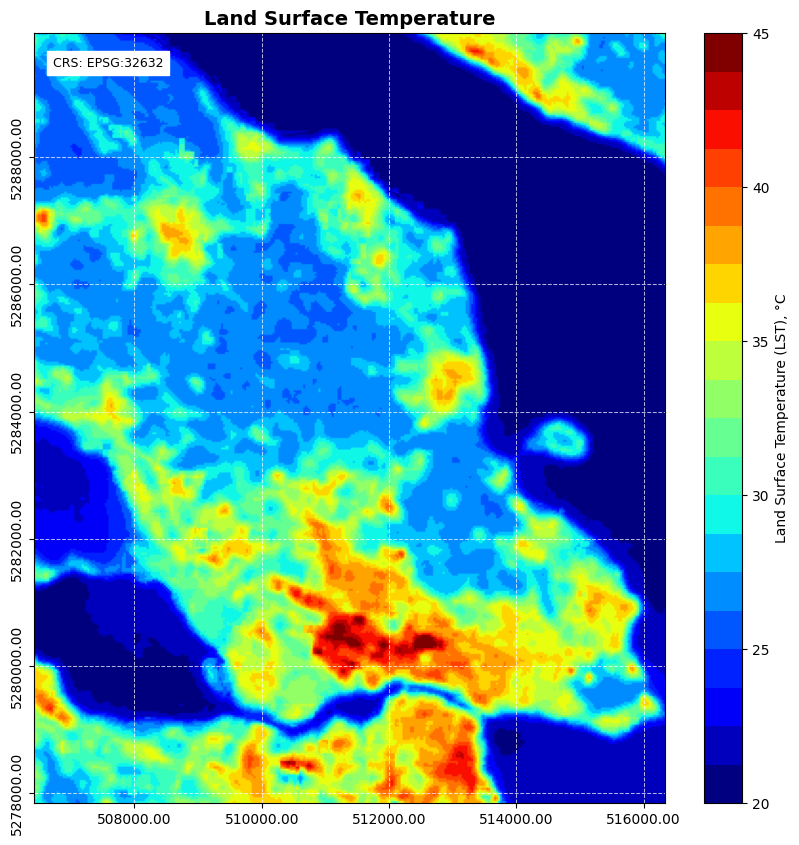

In [15]:
import geopandas as gpd
from matplotlib import ticker
import matplotlib.transforms

from pyproj import Transformer
from rasterio.windows import from_bounds

# Load the shapefile of Konstanz (WGS84 projection) for geographic boundary filtering
shapefile = r"./shapefiles/kn_boundary.shp"
gdf = gpd.read_file(shapefile)

# Extract the bounding box and CRS of the shapefile
shapefile_bounds = gdf.total_bounds
shapefile_crs = gdf.crs

# Define the target CRS and define transformer
with rasterio.open(file['path']) as band_data:
    target_crs = band_data.crs

# target_crs = "EPSG:32632"
transformer = Transformer.from_crs(shapefile_crs, target_crs, always_xy=True)

# Transform coordinates for the area of interst
minx, miny, maxx, maxy = shapefile_bounds
minx_new, miny_new = transformer.transform(minx, miny)
maxx_new, maxy_new = transformer.transform(maxx, maxy)
aoi_bounds = (minx_new, miny_new, maxx_new, maxy_new)

# Extract band data for LST calculation and plotting
band_name = 'ST_B10'

for file in file_list:
    if file['bandname'] == band_name:
        with rasterio.open(file['path']) as band_data:
            # Extract NoData value for masking
            no_data_value = band_data.nodata

            # Define AOI window and read the data
            aoi_window = from_bounds(*aoi_bounds, transform=band_data.transform)
            band_data_array = band_data.read(1, window=aoi_window)
            
            # Mask out NoData values
            masked_data = np.where(np.isclose(band_data_array, no_data_value, atol=1e-5),
                                   np.nan, band_data_array)
            
            # Apply corrections: https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-temperature
            corrected_data = (masked_data * 0.00341802 + 149.0) - 273.15
            
            # Calculate the transform for the window
            window_transform = band_data.window_transform(aoi_window)

# Plot Land Surface Temperature
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('jet', 20)
cmap.set_bad(color='white')

# Define the extent for the image
extent = (aoi_bounds[0], aoi_bounds[2], aoi_bounds[1], aoi_bounds[3])
im = ax.imshow(corrected_data, cmap=cmap, vmin=20, vmax=45, extent=extent)

# Add a color bar
plt.colorbar(im, fraction=0.05, label='Land Surface Temperature (LST), °C')

# Format xaxis and yaxis ticks
def fmt_two_digits(axis, pos):
    return f'{axis:.2f}'
ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmt_two_digits))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(fmt_two_digits))

for label in ax.get_yticklabels():
    label.set_rotation(90)
    label.set_verticalalignment('center')

# Set the title for the plot
plt.title('Land Surface Temperature', fontsize=14, fontweight='bold')

# Add Grid
ax.grid(color='white', linestyle='--', linewidth=0.75, alpha=0.7)

# Add Text
text = (f"CRS: {target_crs}")

# Add Description
plt.figtext(0.21, 0.85, text, ha='left', va='center', fontsize=9, backgroundcolor='w')

# Display the plot
plt.show()